In [14]:
import math
import matplotlib.pyplot as plt
import numpy as np
from disturbances import IntegratedWhiteNoise
import os
from constants import *
from diff_calc import wind_force, vector_to_xy_components, get_mass_matrix
import pandas as pd

In [15]:
current_velocity = IntegratedWhiteNoise(0, 0.514, 0.1, 0.001)
current_direction = IntegratedWhiteNoise(0, 360, 100, 1)
wind_velocity = IntegratedWhiteNoise(0, 7.716, 2, 2)
wind_direction = IntegratedWhiteNoise(0, 360, 200, 7)

wind = np.zeros((5, 100))
for i in range(100):
    wind[0, i] = wind_velocity.get_value()
    wind[1, i] = wind_direction.get_value()
    vec = vector_to_xy_components(wind[0, i], wind[1, i])
    wind[2:, i] = wind_force(vec, wind[1, i], np.array([0, 0, 0]))

pd.DataFrame(wind)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.982123,1.982096,1.995457,1.952214,1.936684,1.918181,1.934918,1.970053,1.925215,1.917663,...,1.801354,1.803108,1.821111,1.804196,1.836186,1.822875,1.787815,1.804298,1.783710,1.794490
1,199.950919,200.045664,199.942223,199.979300,199.897555,199.846207,199.700335,199.704871,199.711865,199.752082,...,199.293363,199.255651,199.266710,199.231655,199.264074,199.354457,199.355512,199.334219,199.406852,199.386733
2,2.641466,3.718900,2.583729,2.862269,2.001339,1.518386,0.551321,0.596195,0.606622,0.835735,...,0.427705,0.604249,0.560792,0.731642,0.583355,0.210614,0.199495,0.271437,0.076981,0.119400
3,11.740233,10.565605,12.000509,11.061747,11.775287,12.036227,13.330132,13.791750,13.130491,12.772801,...,11.607961,11.439091,11.729225,11.314860,11.909798,12.134779,11.675858,11.817769,11.754833,11.852129
4,48.672436,43.802684,49.751481,45.859579,48.817761,49.899561,55.263808,57.177575,54.436141,52.953234,...,48.124064,47.423965,48.626797,46.908932,49.375415,50.308136,48.405551,48.993881,48.732962,49.136331


In [16]:
mass_inv = np.linalg.inv(get_mass_matrix())
mass_inv.dot(get_mass_matrix())

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [17]:
h = 0.01
it = 1000

vel = np.zeros((3, it))
pos = np.zeros((3, it))

for i in range(it-1):
    v = wind_velocity.get_value()
    d = wind_direction.get_value()
    vec = vector_to_xy_components(v, d)
    f = wind_force(vec, d, vel[:, i])
    force = np.array([100, 100, 0])
    
    vel[:, i+1] = vel[:, i] + h * mass_inv.dot(force + f)
    pos[:, i+1] = pos[:, i] + h * mass_inv.dot(force + f) * (i*h)

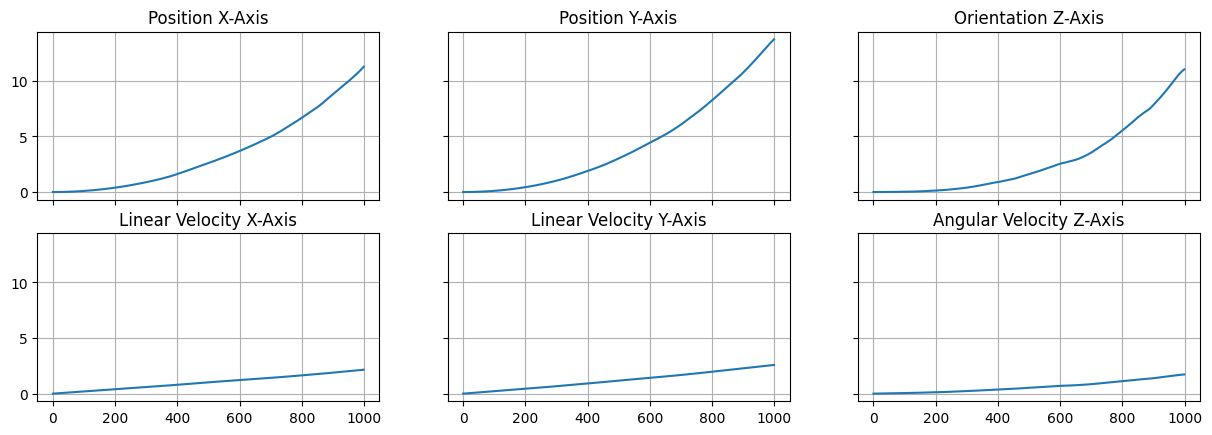

In [18]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
ax[0, 0].plot(range(it), pos[0, :])
ax[0, 1].plot(range(it), pos[1, :])
ax[0, 2].plot(range(it), pos[2, :])

ax[1, 0].plot(range(it), vel[0, :])
ax[1, 1].plot(range(it), vel[1, :])
ax[1, 2].plot(range(it), vel[2, :])
ax[0, 0].set_title('Position X-Axis')
ax[0, 1].set_title('Position Y-Axis')
ax[0, 2].set_title('Orientation Z-Axis')
ax[1, 0].set_title('Linear Velocity X-Axis')
ax[1, 1].set_title('Linear Velocity Y-Axis')
ax[1, 2].set_title('Angular Velocity Z-Axis')

for i in range(2):
    for j in range(3):
        ax[i, j].grid(True)
fig.set_figwidth(15)
plt.show()